Dataset Name:
sx-stackoverflow


Types of Interactions:

- sx-stackoverflow-a2q: User u answered user v's question at time t.

- sx-stackoverflow-c2q: User u commented on user v's question at time t.

- sx-stackoverflow-c2a: User u commented on user v's answer at time t.

# Loading the Dataset

In [1]:
# Reading the first few lines of the uploaded file to understand its structure
with open("./stack_limited.txt", "r") as file:
    sample_lines = [file.readline().strip() for _ in range(10)]

sample_lines

['9 8 1217567877',
 '1 1 1217573801',
 '13 1 1217606247',
 '17 1 1217617639',
 '48 2 1217618182',
 '17 1 1217618239',
 '19 9 1217618357',
 '13 23 1217618560',
 '13 11 1217618799',
 '23 23 1217619360']

The uploaded file appears to have a simple structure where each line represents an interaction, with the format:

Source User ID
Target User ID
Timestamp
Source User IDTarget User IDTimestamp

For example, in the first line:

Source User ID: 9
Target User ID: 8
Timestamp: 1217567877 (This seems to be a Unix timestamp, representing seconds since the epoch)

To further understand the dataset, we can perform some basic analyses:

- Get a distribution of the number of interactions per user.
- Identify the earliest and latest timestamps in the dataset to understand the time range.
- Determine the most active users (based on the number of interactions they've had).

In [13]:
import pandas as pd

# Loading the data into a DataFrame
column_names = ['Source', 'Target', 'Timestamp']
df = pd.read_csv("./stack_limited.txt", sep=' ', header=None, names=column_names)

# 1. Distribution of interactions per user (both as a source and target)
interaction_counts_source = df['Source'].value_counts()
interaction_counts_target = df['Target'].value_counts()
total_interactions = interaction_counts_source.add(interaction_counts_target, fill_value=0)

# 2. Identify the earliest and latest timestamps
earliest_timestamp = pd.to_datetime(df['Timestamp'].min(), unit='s')
latest_timestamp = pd.to_datetime(df['Timestamp'].max(), unit='s')

# 3. Determine the most active users
most_active_users = total_interactions.nlargest(5)

print("Time Range")
earliest_timestamp, latest_timestamp

Time Range


(Timestamp('2008-08-01 05:17:57'), Timestamp('2008-10-15 16:19:32'))

## Time Range

In [14]:
time_period = [earliest_timestamp, latest_timestamp]
time_period

[Timestamp('2008-08-01 05:17:57'), Timestamp('2008-10-15 16:19:32')]

## Most Active Users

In [15]:
print("Most Active Users:\n")
print("User  - Interactions")
print(most_active_users)

Most Active Users:

User  - Interactions
3043    626.0
572     604.0
1965    571.0
91      458.0
3153    429.0
dtype: float64


## distribution of interactions per user

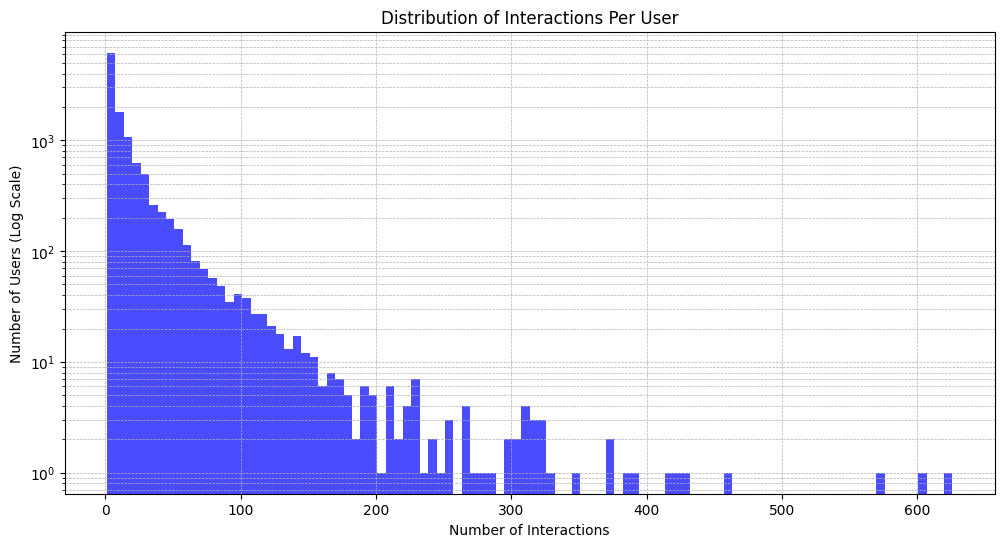

In [16]:
import matplotlib.pyplot as plt

# Plotting distribution of interactions per user
plt.figure(figsize=(12, 6))
plt.hist(total_interactions, bins=100, color='blue', alpha=0.7)
plt.yscale('log')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users (Log Scale)')
plt.title('Distribution of Interactions Per User')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

From the histogram we can see the following:

- A large number of users have very few interactions (between 1 and around 50). This is common in many online platforms where a majority of users are less active.
- As the number of interactions increases, the number of users having those interactions decreases. This is evident from the rapidly declining histogram bars.
- Very few users have extremely high interactions, but they can be considered as the "power users" or the most active members of the community.

This kind of distribution is typical of many social networks and online platforms, where a small percentage of users contribute a significant portion of the content or interactions, often referred to as the "80-20" rule or Pareto principle.

# Interactions over time

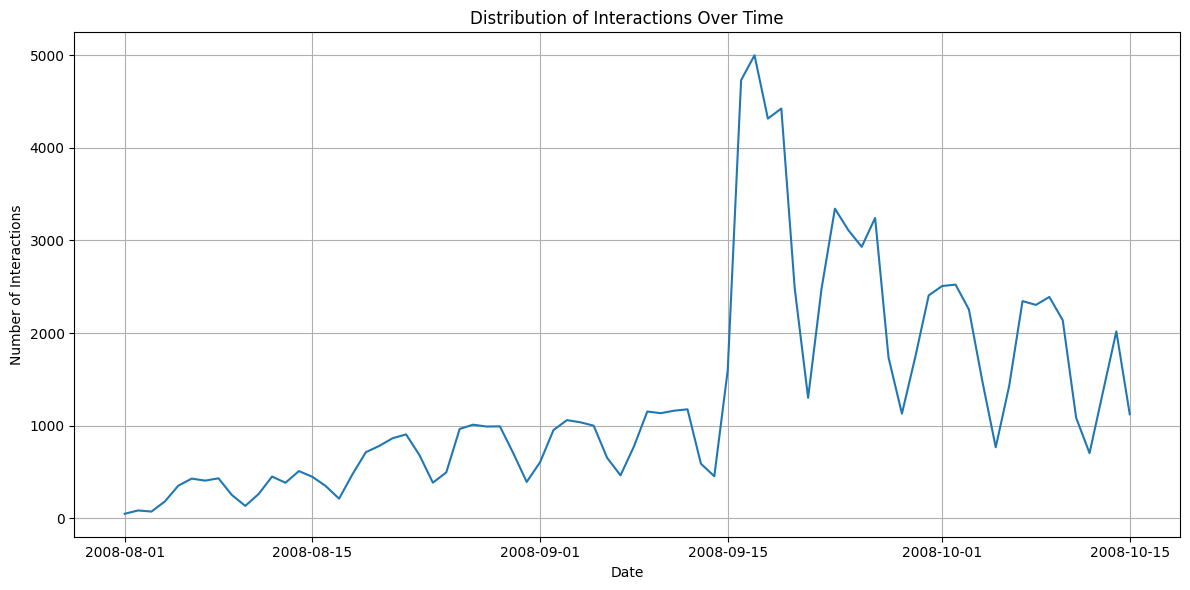

In [19]:
# Converting the timestamp column to a datetime format for easier analysis
df['datetime'] = pd.to_datetime(df['Timestamp'], unit='s')


# Plotting the distribution of interactions over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df.groupby(df['datetime'].dt.date).size().plot()
plt.title('Distribution of Interactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.grid(True)
plt.tight_layout()

- Interaction Distribution: The plot shows the distribution of interactions over time. We can observe a general upward trend in interactions, with some notable peaks.

# Splitting out Time Intances Data 

We will use the Uniform Time Intervals:

Divide the entire time range into N equal intervals.
This approach ensures that each interval has the same length but does not guarantee an even distribution of events across intervals.

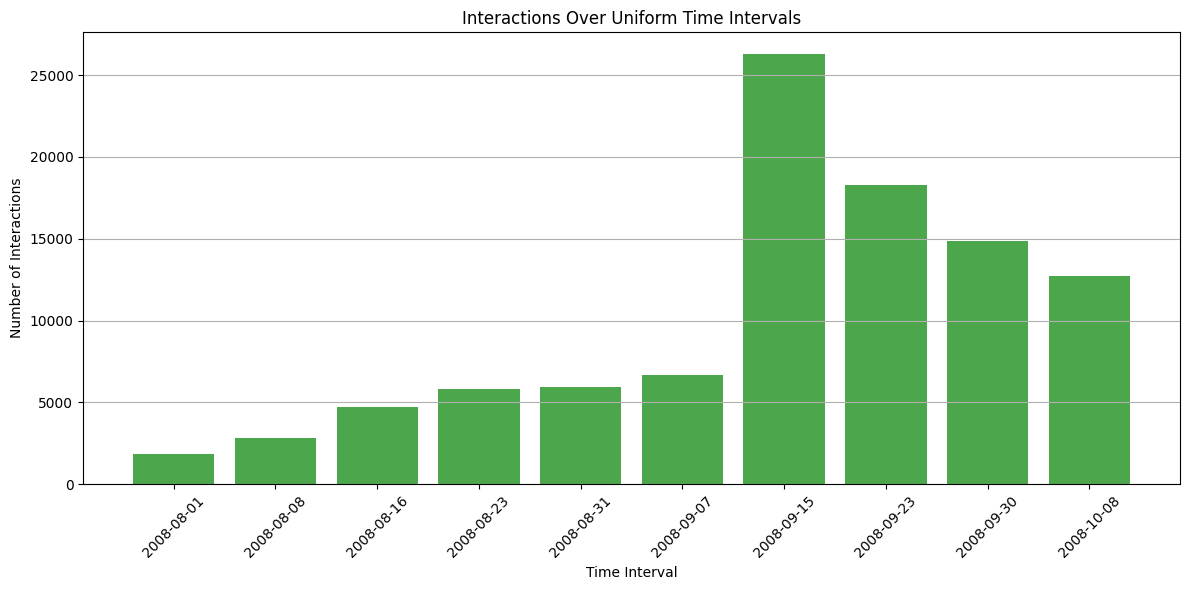

In [6]:
# Setting the number of intervals
N = 10

# Calculating the length of each interval
total_seconds = (latest_timestamp - earliest_timestamp).total_seconds()
interval_length = total_seconds / N

# Creating the time intervals
intervals = [earliest_timestamp + pd.to_timedelta(i * interval_length, unit='s') for i in range(N+1)]

# Counting the number of interactions in each interval
interaction_counts = []
for i in range(N):
    count = df[(df['Timestamp'] >= intervals[i].timestamp()) & (df['Timestamp'] < intervals[i+1].timestamp())].shape[0]
    interaction_counts.append(count)

# Plotting the interactions over the intervals
plt.figure(figsize=(12, 6))
plt.bar(range(N), interaction_counts, color='green', alpha=0.7)
plt.xticks(range(N), [str(intervals[i].date()) for i in range(N)], rotation=45)
plt.xlabel('Time Interval')
plt.ylabel('Number of Interactions')
plt.title('Interactions Over Uniform Time Intervals')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

Observations:

- There's a noticeable pattern where activity seems to increase in the middle intervals and then decrease towards the end. This could be due to various factors, such as day of the week effects, special events, or platform changes.
- The highest activity level occurs around the interval starting from September 1, 2008.

## Define individual graph objects for the time intervals

#### ll be using the networkx library to create these graph objects. 

In [7]:
import networkx as nx

# Creating individual graph objects for each time interval
graphs = []

for i in range(N):
    # Filter interactions for the current interval
    interval_data = df[(df['Timestamp'] >= intervals[i].timestamp()) & (df['Timestamp'] < intervals[i+1].timestamp())]
    
    # Create a directed graph for the interval
    G = nx.from_pandas_edgelist(interval_data, 'Source', 'Target', create_using=nx.DiGraph())
    graphs.append(G)

# Checking the number of nodes and edges in each graph
graph_info = [(len(G.nodes()), len(G.edges())) for G in graphs]

In [15]:
print("Total Nodes - Total Edges")
print(graph_info)

Total Nodes - Total Edges
[(402, 1669), (710, 2537), (1141, 4357), (1598, 5429), (1792, 5571), (1976, 6361), (6891, 25326), (5312, 17609), (4917, 14327), (4685, 12338)]


In [8]:
print("Our Graphs")
graphs

Our Graphs


# for each graph take the edges E1,E2,...En and the unique nodes  V1,V2...Vn


In [9]:
# Extracting edges and unique nodes for each graph
edges_list = [list(G.edges()) for G in graphs]
nodes_list = [list(G.nodes()) for G in graphs]

# Centrality Analysis

Centrality analysis helps us identify the most important nodes in a network. There are various centrality measures, each capturing different types of "importance" or "influence" of a node within a network.

For this analysis, we'll focus on the following centrality measures:

- Degree Centrality: The number of links incident upon a node.
- Betweenness Centrality: The number of times a node acts as a bridge along the shortest path between two other nodes.
- Eigenvector Centrality: A measure of the influence of a node in a network.

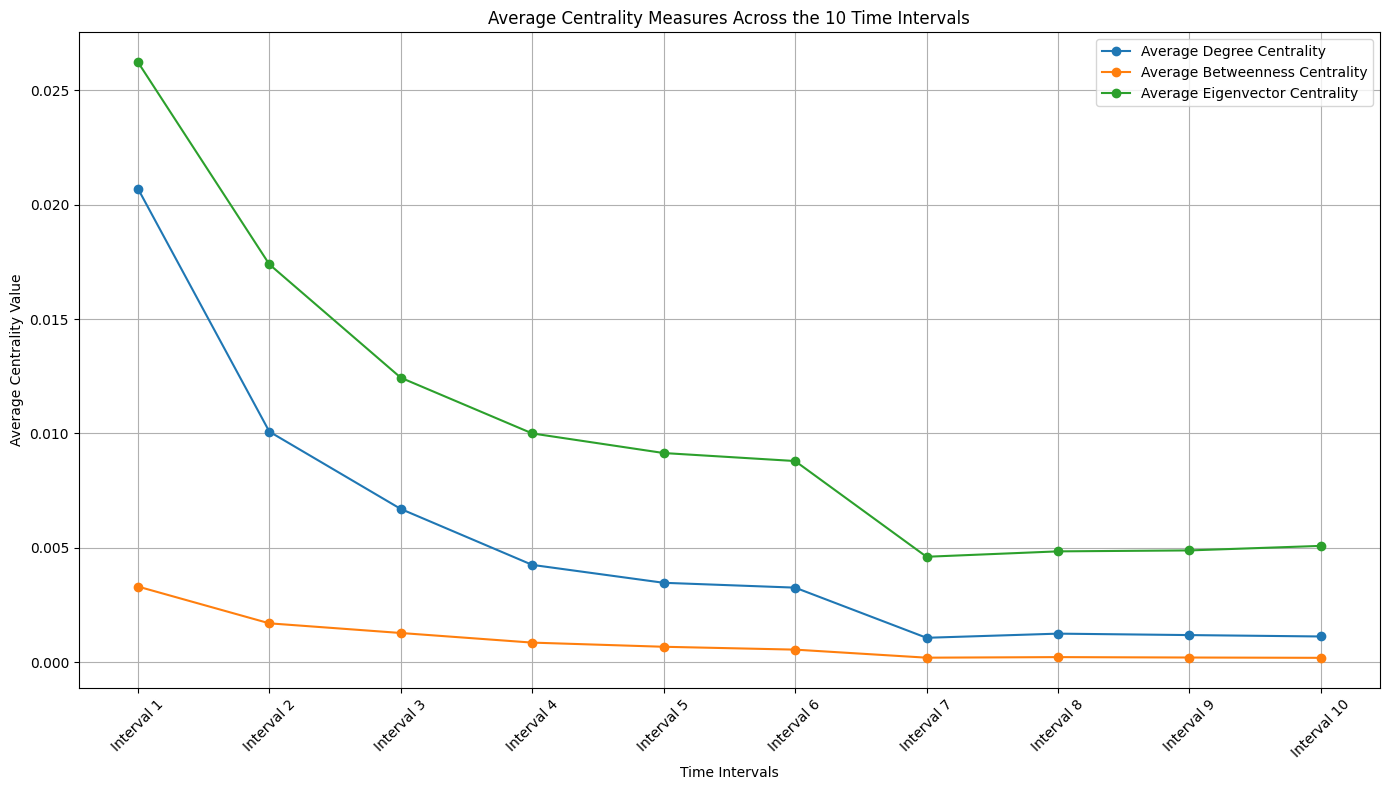

In [22]:
# Calculating centrality measures for each graph

degree_centralities = [nx.degree_centrality(G) for G in graphs]
betweenness_centralities = [nx.betweenness_centrality(G, normalized=True, endpoints=False) for G in graphs]
eigenvector_centralities = [nx.eigenvector_centrality(G, max_iter=500) if len(G) > 0 else {} for G in graphs]

# Averaging the centrality measures for visualization
avg_degree = [sum(dc.values())/len(dc) if len(dc) > 0 else 0 for dc in degree_centralities]
avg_betweenness = [sum(bc.values())/len(bc) if len(bc) > 0 else 0 for bc in betweenness_centralities]
avg_eigenvector = [sum(ec.values())/len(ec) if len(ec) > 0 else 0 for ec in eigenvector_centralities]

# Visualizing the average centrality measures across the 10 intervals
plt.figure(figsize=(14, 8))

plt.plot(avg_degree, '-o', label='Average Degree Centrality')
plt.plot(avg_betweenness, '-o', label='Average Betweenness Centrality')
plt.plot(avg_eigenvector, '-o', label='Average Eigenvector Centrality')

plt.title('Average Centrality Measures Across the 10 Time Intervals')
plt.xlabel('Time Intervals')
plt.ylabel('Average Centrality Value')
plt.xticks(ticks=range(10), labels=[f"Interval {i+1}" for i in range(10)], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
